In [70]:
import re
import pandas as pd
import geonamescache
from unidecode import unidecode

gc = geonamescache.GeonamesCache()
cities = gc.get_cities()
# print(cities)

black_lst = ["Can", "Come", "Of"]
city_dict_regexp = {}
city_lst = []
city_lst_regexp = []
city_str = ""
df_data = []

items = cities.items()
for item in items:
    city = item[1]['name']
    countrycode = item[1]['countrycode']
    latitude = item[1]['latitude']
    longitude = item[1]['longitude']
    if city not in black_lst:
        city = unidecode(city)
        city_dict_regexp[city] = [countrycode, latitude, longitude]

city_lst_regexp = [*city_dict_regexp]
city_lst_regexp.sort(key = len)  
city_lst_regexp.reverse()

city_dict_regexp = {k.lower(): v for k, v in city_dict_regexp.items()}

city_str = '|'.join(city_lst_regexp)
city_str = "\\b(" + city_str + ")\\b"

regexp = re.compile(r"(?P<city>{cities})".format(cities=city_str), re.I)


In [71]:
count = 0
cnt_ok = 0
cnt_nok = 0

country_dict = gc.get_countries()

with open("data/headlines.txt", "r") as fn:
    lines = fn.readlines()
    for line in lines:
        count = count + 1
        line = line.strip()
        result = regexp.search(line)
        if result != None:
            cnt_ok += 1
            city = result.group('city')
            city_hlp = city.lower()
            
            if city_hlp in city_dict_regexp:
                cc = city_dict_regexp[city_hlp][0]
                country = country_dict[cc]['name']
                latitude = city_dict_regexp[city_hlp][1]
                longitude = city_dict_regexp[city_hlp][2]
                # print(cnt_ok, "--", line, "--", city, "--", latitude, "--", longitude, "--", cc, "--", country)
                df_data.append((line, city, latitude, longitude, cc, country))
   
            else:
                None
                # print(count, "DBG-002:", "--", city, "not found in dictionary")
        else:
            cnt_nok +=1
            # print(count, "DBG-001:", "--", line, "not found in headlines")


In [72]:
df = pd.DataFrame(df_data, columns =['headline', 'city', 'latitude', 'longitude', 'countrycode', 'country'])
print("Nr of entries in data frame", df.shape[0])
df.to_csv("output.csv", index=False, header=True)
print(df.iloc[:10])

Nr of entries in data frame 613
                                  headline           city  latitude  \
0                 Zika Outbreak Hits Miami          Miami  25.77427   
1          Could Zika Reach New York City?  New York City  40.71427   
2        First Case of Zika in Miami Beach    Miami Beach  25.79065   
3  Mystery Virus Spreads in Recife, Brazil         Recife  -8.05389   
4  Dallas man comes down with case of Zika         Dallas  44.91928   
5        Trinidad confirms first Zika case       Trinidad -33.51650   
6   Zika Concerns are Spreading in Houston        Houston  29.76328   
7    Geneve Scientists Battle to Find Cure         Geneve  46.20222   
8    The CDC in Atlanta is Growing Worried        Atlanta  33.74900   
9       Zika Infested Monkeys in Sao Paulo      Sao Paulo -23.54750   

   longitude countrycode        country  
0  -80.19366          US  United States  
1  -74.00597          US  United States  
2  -80.13005          US  United States  
3  -34.88111      

In [73]:
print("Total nr of headlines:",count)   
print("Nr OK",cnt_ok)   
print("Nr NOK",cnt_nok)   

Total nr of headlines: 650
Nr OK 613
Nr NOK 37


In [74]:
coordinates = list(zip(df.longitude, df.latitude))
# print(coordinates)
# print(len(coordinates))

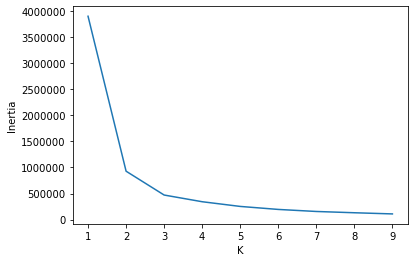

In [75]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

k_values = range(1, 10)
inertia_values = [KMeans(k).fit(coordinates).inertia_ 
                  for k in k_values]

plt.plot(k_values, inertia_values)
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [76]:
n_clusters = 6
cluster_model = KMeans(n_clusters)
epi_centers = cluster_model.fit_predict(coordinates)

In [77]:
df['cluster'] = pd.Series(epi_centers)
print(df.iloc[:10])
# print(df.loc[df['epi_center'] == 0])

                                  headline           city  latitude  \
0                 Zika Outbreak Hits Miami          Miami  25.77427   
1          Could Zika Reach New York City?  New York City  40.71427   
2        First Case of Zika in Miami Beach    Miami Beach  25.79065   
3  Mystery Virus Spreads in Recife, Brazil         Recife  -8.05389   
4  Dallas man comes down with case of Zika         Dallas  44.91928   
5        Trinidad confirms first Zika case       Trinidad -33.51650   
6   Zika Concerns are Spreading in Houston        Houston  29.76328   
7    Geneve Scientists Battle to Find Cure         Geneve  46.20222   
8    The CDC in Atlanta is Growing Worried        Atlanta  33.74900   
9       Zika Infested Monkeys in Sao Paulo      Sao Paulo -23.54750   

   longitude countrycode        country  cluster  
0  -80.19366          US  United States        0  
1  -74.00597          US  United States        0  
2  -80.13005          US  United States        0  
3  -34.88111  

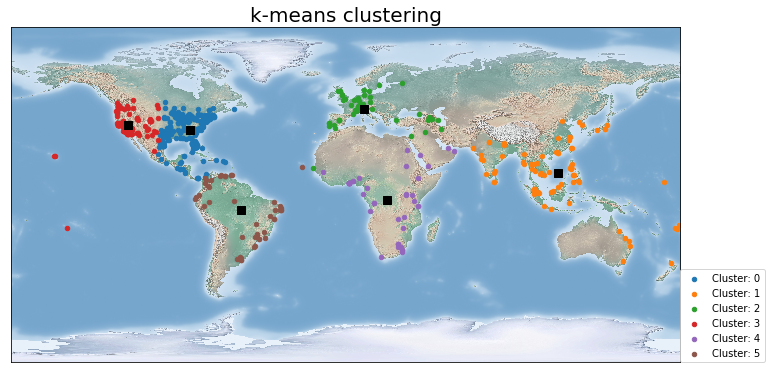

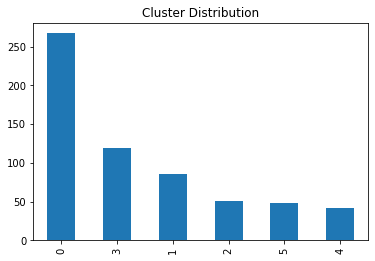

In [78]:
from mpl_toolkits.basemap import Basemap
map_plotter = Basemap()
plt.figure(figsize=(12, 8))

import numpy as np

for cluster, grouped in df.groupby("cluster"):
    map_plotter.scatter(grouped["longitude"], grouped["latitude"], 20, marker="o", label=f"Cluster: {cluster}")

# Add a legend and title (put legend to right of plot)
ax = plt.gca()
ax.legend(loc=(1, 0))
_ = ax.set_title("k-means clustering", size=20)
    
map_plotter.shadedrelief()

centers = cluster_model.cluster_centers_
for c in centers:
    # print(c[0], c[1])
    map_plotter.scatter(c[0], c[1], s=50, c='k', marker='s')


plt.show()

# df["cluster"].value_counts()
_ = df['cluster'].value_counts().plot.bar(title='Cluster Distribution')


In [79]:
def haversine(crd1, crd2):

    lat1, lon1 = np.radians(crd1)
    lat2, lon2 = np.radians(crd2)
   
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = 6371 * c
    
    return distance

# New York - Miami
ret = haversine([40.71427,-74.00597],[25.77427,-80.19366])
print(ret,"km between New-York and Miami")


1756.8373422039303 km between New-York and Miami


                                  headline           city  latitude  \
0                 Zika Outbreak Hits Miami          Miami  25.77427   
1          Could Zika Reach New York City?  New York City  40.71427   
2        First Case of Zika in Miami Beach    Miami Beach  25.79065   
3  Mystery Virus Spreads in Recife, Brazil         Recife  -8.05389   
4  Dallas man comes down with case of Zika         Dallas  44.91928   
5        Trinidad confirms first Zika case       Trinidad -33.51650   
6   Zika Concerns are Spreading in Houston        Houston  29.76328   
7    Geneve Scientists Battle to Find Cure         Geneve  46.20222   
8    The CDC in Atlanta is Growing Worried        Atlanta  33.74900   
9       Zika Infested Monkeys in Sao Paulo      Sao Paulo -23.54750   

   longitude countrycode        country  cluster  cluster_dbscan  
0  -80.19366          US  United States        0               0  
1  -74.00597          US  United States        0               0  
2  -80.13005     

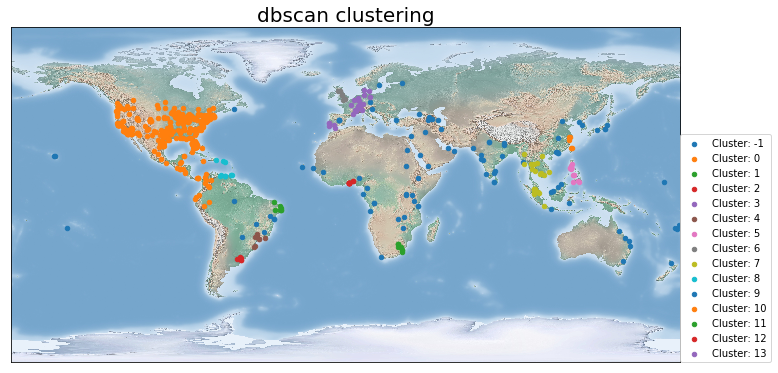

In [82]:
# Continuing with dbscan
epsilon = 400
min_points = 5

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

from mpl_toolkits.basemap import Basemap
map_plotter = Basemap()
plt.figure(figsize=(12, 8))

# print("Nr coordinates:",len(coordinates))
# print("Shape:",coordinates)

cluster_model = DBSCAN(eps=epsilon, min_samples=min_points, metric=haversine)

# print(cluster_model)
disease_clusters = cluster_model.fit_predict(coordinates)
# print("Nr clusters:",len(set(disease_clusters)))

df['cluster_dbscan'] = pd.Series(disease_clusters)
print(df.iloc[:10])

for cluster_dbscan, grouped in df.groupby("cluster_dbscan"):
    map_plotter.scatter(grouped["longitude"], grouped["latitude"], 20, marker="o", label=f"Cluster: {cluster_dbscan}")

# Add a legend and title (put legend to right of plot)
ax = plt.gca()
ax.legend(loc=(1, 0))
_ = ax.set_title("dbscan clustering", size=20)
    
map_plotter.shadedrelief()

plt.show()


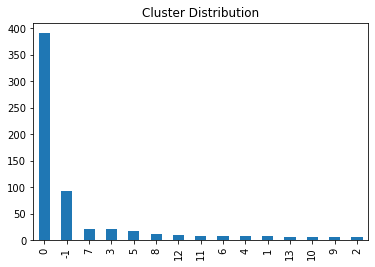

In [81]:
# df["cluster_dbscan"].value_counts()
_ = df['cluster_dbscan'].value_counts().plot.bar(title='Cluster Distribution')